In [38]:
import numpy as np
import pandas as pd

from seaborn import displot
from tqdm import tqdm
from os import listdir
from scipy.stats import linregress
from matplotlib import pyplot as plt
from uncertainties import ufloat
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN

plt.style.use('seaborn-v0_8')

In [39]:

data = []
steps = []
for filename in sorted(listdir('./cfg_on_Cu'), key=lambda x: int(x.split('.')[1]))[100::5]:
    with open('./cfg_on_Cu/'+ filename) as file:
        
        lines = file.readlines()
        frame = [[float(x) for x in lines[i+1].split(' ')] for i in range(len(lines)) if 'Au ' in lines[i]]
        if len(frame) != 30: print(len(frame))
        data.append(frame)
        steps.append(int(filename.split('.')[1]))
        

data = np.array(data)
time = np.array(steps) / 1e6
data[:, :, :2] *= 28.72
data[:, :, 3] *= 53.85
data.shape

    

(2822, 30, 6)

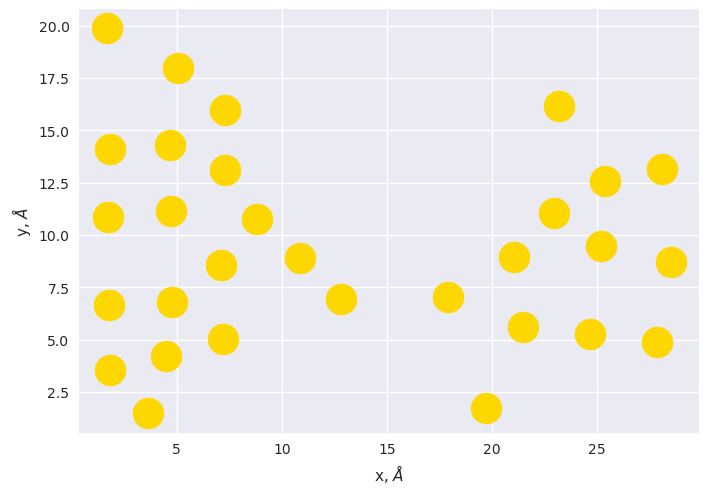

In [13]:

fr = -1

plt.scatter(data[fr][:, 0], data[fr][:, 1], s=500, c='gold')
plt.xlabel('x, $\\AA$')
plt.ylabel('y, $\\AA$');

Метки кластеров: [ 0  1  1  1  1 -1  1  0  0 -1 -1  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1  2
  2 -1 -1  2  2  2]


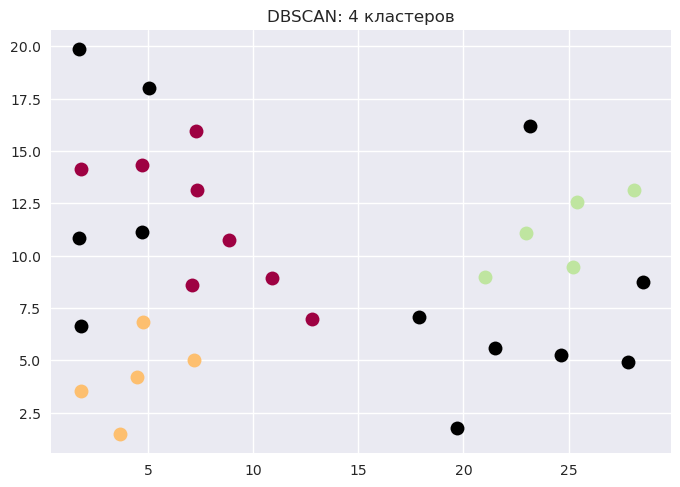

In [14]:
points = np.vstack([data[fr][:, 0], data[fr][:, 1]]).T
points.shape
eps = 2.9
min_samples = 2
db = DBSCAN(eps=eps, min_samples=min_samples).fit(points)

# Получаем метки кластеров
labels = db.labels_

# Выводим результат
print("Метки кластеров:", labels)

# Визуализация
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Точки шума (не принадлежат ни одному кластеру)
        col = [0, 0, 0, 1]  # Черный цвет

    class_member_mask = (labels == k)

    xy = points[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=10)

plt.title(f'DBSCAN: {len(unique_labels)} кластеров')
plt.show()

In [40]:
# Пользовательская метрика расстояния с учетом периодических граничных условий
def periodic_distance(point1, point2, box_size):
    """
    Вычисляет расстояние между двумя точками с учетом периодических граничных условий.
    :param point1: Первая точка (x, y).
    :param point2: Вторая точка (x, y).
    :param box_size: Размер периодической области (ширина и высота).
    :return: Расстояние с учетом периодичности.
    """
    delta = np.abs(point1 - point2)
    delta = np.where(delta > 0.5 * box_size, box_size - delta, delta)
    return np.linalg.norm(delta)

# Функция для создания матрицы расстояний с учетом периодичности
def periodic_dist_matrix(points, box_size):
    """
    Создает матрицу расстояний между всеми точками с учетом периодических граничных условий.
    :param points: Массив точек (N x 2).
    :param box_size: Размер периодической области (ширина и высота).
    :return: Матрица расстояний (N x N).
    """
    dist_matrix = squareform(pdist(points, lambda u, v: periodic_distance(u, v, box_size)))
    return dist_matrix

Метки кластеров: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Средний размер кластеров: 15.0


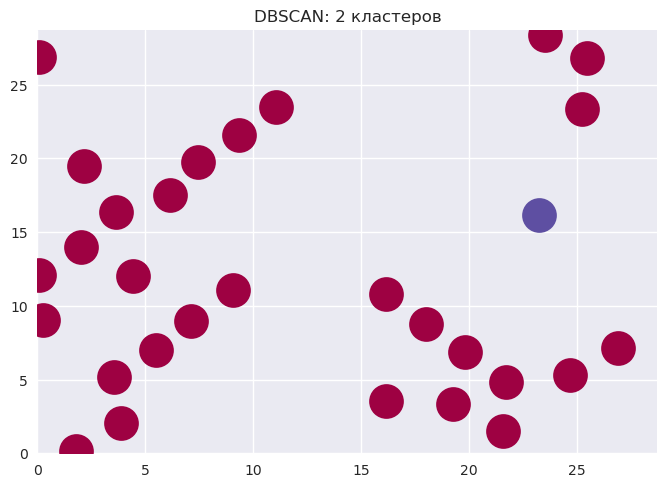

In [51]:
fr = 448
points = np.vstack([data[fr][:, 0], data[fr][:, 1]]).T

# Параметры DBSCAN
eps = 3.61 # Максимальное расстояние между точками в одном кластере
min_samples = 1  # Минимальное количество точек для формирования кластера (1 для учета одиночных атомов)
box_size = 28.72

# Создаем матрицу расстояний с учетом периодичности
dist_matrix = periodic_dist_matrix(points, box_size)
# Применяем DBSCAN
db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(dist_matrix)

# Получаем метки кластеров
labels = db.labels_

# Выводим результат
print("Метки кластеров:", labels)

# Подсчет размера каждого кластера
cluster_sizes = {}
for label in labels:
    if label in cluster_sizes:
        cluster_sizes[label] += 1
    else:
        cluster_sizes[label] = 1

# Вывод размера кластеров
# print("Размеры кластеров:", cluster_sizes)

# Расчет среднего размера кластеров
average_cluster_size = np.mean(list(cluster_sizes.values()))
print("Средний размер кластеров:", average_cluster_size)

# Визуализация
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Точки шума (не принадлежат ни одному кластеру)
        col = [0, 0, 0, 1]  # Черный цвет

    class_member_mask = (labels == k)

    xy = points[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=25)

plt.title(f'DBSCAN: {len(unique_labels)} кластеров')
plt.xlim([0, 28.72])
plt.ylim([0, 28.72])
plt.show()

In [42]:
sizes = []
for frame in data:

    x = frame[:, 0]
    y = frame[:, 1]
    
    points = np.vstack([x, y]).T
    eps = 3.6
    min_samples=1
    

    dist_matrix = periodic_dist_matrix(points, box_size)    
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(dist_matrix)
    

    labels = db.labels_

    # Подсчет размера каждого кластера
    cluster_sizes = {}
    for label in labels:
        if label in cluster_sizes:
            cluster_sizes[label] += 1
        else:
            cluster_sizes[label] = 1

    
    average_cluster_size = np.mean(list(cluster_sizes.values()))
    sizes.append(average_cluster_size)
sizes = np.array(sizes)

(np.float64(2.34), np.int64(448))

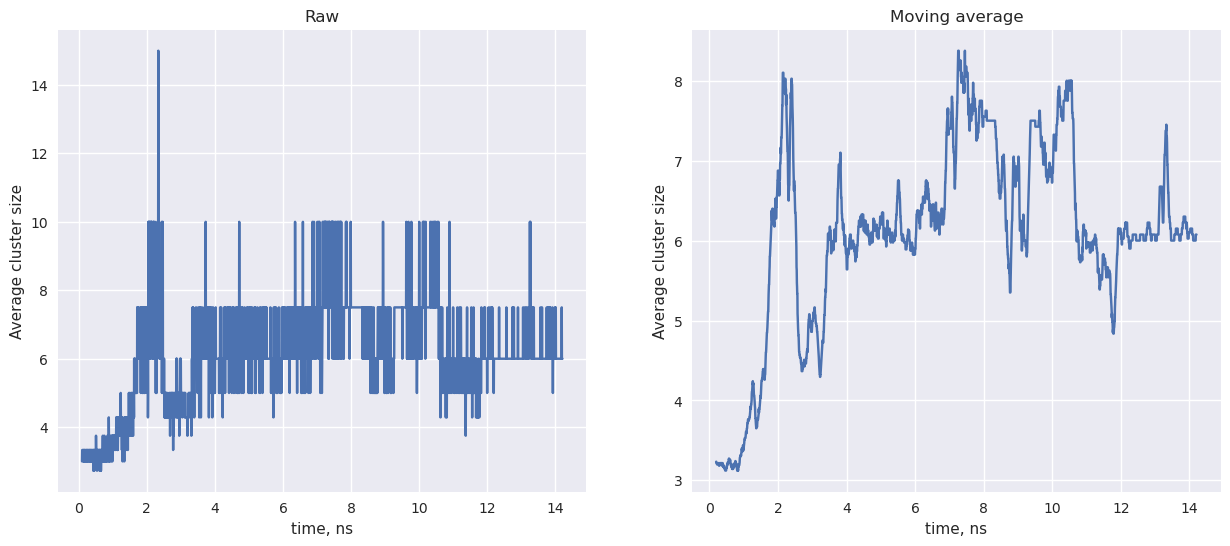

In [48]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

window = 20
fig, axs = plt.subplots(ncols=2, figsize=(15, 6))
axs[0].set_title('Raw')
axs[0].plot(time, sizes)
axs[0].set_xlabel('time, ns')
axs[0].set_ylabel('Average cluster size');

axs[1].set_title('Moving average')
axs[1].plot(time[window -1:], moving_average(sizes, window))
axs[1].set_xlabel('time, ns')
axs[1].set_ylabel('Average cluster size');
time[sizes.argmax()], sizes.argmax()